In [1]:
# Import
from helper_functions.load_data import load_data
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)
from sklearn.metrics import (
    mean_squared_log_error,
)
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor


##### Read in data

In [2]:
# Testing environment parameters
random_state = 42
# Read in data
bike = load_data(
    "train.csv",
    subfolder="data/bike-sharing-demand/",
    sep=",",
    parse_dates=[0],
)
bike.head()


Loading in train.csv...
Data set successfully loaded.



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


##### Feature Engineering
Some renaming of the feature levels and adding of time features

In [3]:

bike["season"] = bike["season"].replace(
    {1: "spring", 2: "summer", 3: "autumn", 4: "winter"}
)
bike["weather"] = bike["weather"].replace(
    {1: "clear", 2: "misty", 3: "rain", 4: "heavy rain"}
)
bike["holiday"] = bike["holiday"].apply(bool)
bike["workingday"] = bike["workingday"].apply(bool)


In [4]:
bike["year"] = bike["datetime"].dt.year.replace({2011: 0, 2012: 1})
print(bike["year"].unique())
bike["month"] = bike["datetime"].dt.month
bike["hour"] = bike["datetime"].dt.hour


[0 1]


Define the numerical, categorical and ordinal features and define their respective transformers.

In [5]:
# Numerical features
numeric_features = [
    "temp",
    "humidity",
    # "windspeed", # Has alot of 0s and does not seem to help...
    "hour",
    "month",
    "year",
]
numeric_transformer = Pipeline(
    steps=[
        ("scaler", MinMaxScaler(feature_range=(0, 1))),
    ]
)


In [6]:
# Categorical features
categorical_features = [
    "weather",
    "workingday",
]  # if we got month, we don't need season. Also, holiday doesn't predict well
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="first")


In [7]:
# Ordinal features
ordinal_features = categorical_features
# Turns out, ordinally encoding here doesn't really help.


To build the model, we first create a ColumnTransformer pipeline, before add it to the overall pipeline containing the regression model used.

In [8]:
# Build preprocessor into pipeline
degree = 10
preprocessor = ColumnTransformer(
    transformers=[
        (
            "numeric",
            numeric_transformer,
            numeric_features,
        ),
        (
            "categoric",
            categorical_transformer,
            categorical_features,
        ),
        (
            "poly1",
            PolynomialFeatures(degree=degree, include_bias=False),
            ["hour"],
        ),  # Rental behavior over hours does not follow a linear trend
        (
            "poly2",
            PolynomialFeatures(degree=degree, include_bias=False),
            ["month"],
        ),  # Rental behavior over months also does not follow a linear trend
    ],
)


In [9]:
# Build the model into pipeline
pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "regression",
            LinearRegression(),
        ),
    ]
)


Create X and y

In [10]:
# For X:
# First, drop the dateTimeIndex/datetime column in case it hasn't been done
bike_pipe = bike.drop("datetime", axis=1)
# 1. Remove "heavy rain" of "weather" feature because it only occurs a few times
# or just assign it to the previous category
# bike_pipe = bike_pipe.drop(bike_pipe.loc[bike_pipe["weather"] == "heavy rain"].index)
bike_pipe["weather"] = bike_pipe["weather"].replace(
    to_replace="heavy rain", value="rain"
)
# 2. Retained all features in the columntransformer
features_included = np.unique(
    numeric_features
    + categorical_features
    + ordinal_features
    + ["hour", "month", "year"]
)
X = bike_pipe[features_included]
print(f"Features included into the model: {features_included}")
# For y:
# Just use "count", but if you don't scale it, your model is screwed.
# y = bike_pipe["count"]
# MinMax like helps a bit:
# y = bike_pipe["count"] / bike_pipe["count"].max()
# Log-transform is the killer, though, and conveniently the one used on Kaggle:
y = np.log1p(bike_pipe["count"])
# Check shapes
print("Shape dimensions of X and y before train_test_split: ", X.shape, y.shape)


Features included into the model: ['hour' 'humidity' 'month' 'temp' 'weather' 'workingday' 'year']
Shape dimensions of X and y before train_test_split:  (10886, 7) (10886,)


Train/test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=random_state,
    # stratify=bike["count"], # We should always stratify but it is not possible here. Probably not realistic in when we are regressing but not classifying
)
print(
    "Shape dimensions of X_train, X_test, y_train and y_test after train_test_split: ",
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape,
)


Shape dimensions of X_train, X_test, y_train and y_test after train_test_split:  (8708, 7) (2178, 7) (8708,) (2178,)


##### Train model
First, setup parameters and then run grid search (we don't really do exhaustive GridSearch here) to tune hyperparameters

In [12]:
param_grid = {
    # Linear Regression
    "regression__fit_intercept": [True, False],
}
pipe_gridCV = GridSearchCV(
    pipe, param_grid, cv=10, scoring="r2", refit=True, n_jobs=20
)

Quick check on x and y train

In [13]:
X_train.head()

,hour,humidity,month,temp,weather,workingday,year
2815,5,83,7,27.88,clear,True,0
8695,16,39,8,36.90,clear,False,1
8406,15,41,7,32.80,clear,True,1
1543,4,93,4,14.76,misty,False,0
4952,10,45,11,13.12,clear,False,0


In [14]:
y_train.head()

2815    3.583519
8695    6.111467
8406    5.624018
1543    1.791759
4952    5.303305
Name: count, dtype: float64

Fit model and show model

In [15]:
pipe_gridCV.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['temp',
                                                                          'humidity',
                                                                          'hour',
                                                                          'month',
                                                                          'year']),
                                                                        ('categoric',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['weather',
                                                                          'workingday']),
                                                                        ('poly1',
                                                                         PolynomialFeatures(degree=10,
                                                                                            include_bias=False),
                                                                         ['hour']),
                                                                        ('poly2',
                                                                         PolynomialFeatures(degree=10,
                                                                                            include_bias=False),
                                                                         ['month'])])),
                                       ('regression', LinearRegression())]),
             n_jobs=20, param_grid={'regression__fit_intercept': [True, False]},
             scoring='r2')

Obtain best params & coefs of the gridscore

In [16]:
best_params = pipe_gridCV.best_params_
print(f"Best params: {best_params}")
best_estimators = pipe_gridCV.best_estimator_.named_steps["regression"]
print(f"Best estimators: {best_estimators}")
coefs = pipe_gridCV.best_estimator_["regression"].coef_
print(f"Best coefs: {coefs}")
intercept = pipe_gridCV.best_estimator_["regression"].intercept_
print(f"Best intercept: {intercept}")
best_score = pipe_gridCV.best_score_
print(f"The best score is {best_score:.3f}.")

Best params: {'regression__fit_intercept': True}
Best estimators: LinearRegression()
Best coefs: [ 1.06525694e+00 -2.46716805e-01 -2.23686781e-02  1.26990656e-01
  4.74785099e-01 -5.32280651e-02 -5.58243005e-01 -6.36514635e-02
  5.83661801e-03 -5.08318011e-01  2.70032878e-02  6.45392443e-02
 -1.84253292e-02  2.29778548e-03 -1.57008996e-04  6.11465258e-06
 -1.27748430e-07  1.11415052e-09  1.49024000e+00  4.20004015e-01
 -1.26452353e+00  7.41367531e-01 -2.16879805e-01  3.70245942e-02
 -3.86669412e-03  2.44434784e-04 -8.62674964e-06  1.30942410e-07]
Best intercept: 1.5123198506365219
The best score is 0.812.


Inspect coefficients:  
(see here: https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html)

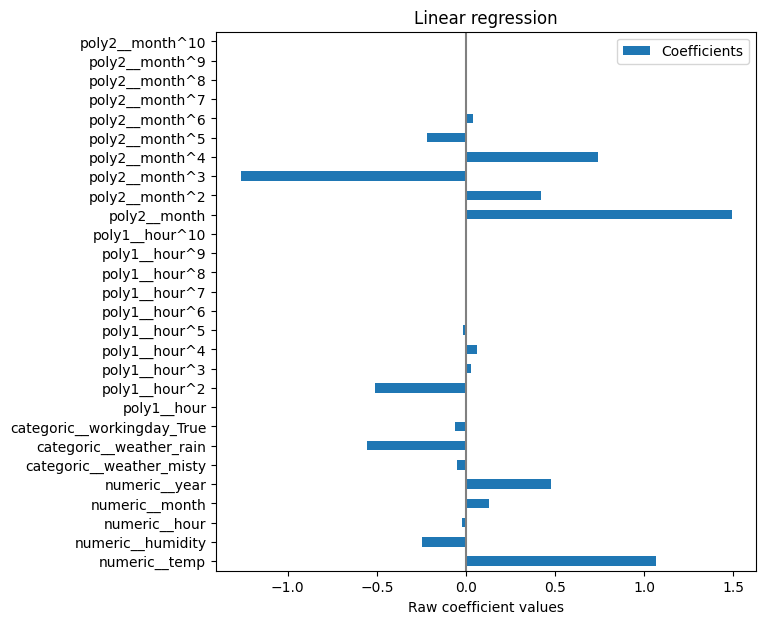

In [17]:
feature_names = pipe_gridCV.best_estimator_["preprocessor"].get_feature_names_out()
coefs = pd.DataFrame(
    pipe_gridCV.best_estimator_["regression"].coef_,
    columns=["Coefficients"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Linear regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

Since the coefficients are scaled to the same level (MinMax in the pipeline), we can safely interprete them. It is important to note though that these plots demonstrate **conditional dependencies** amonth the features, meaning the dependencies between a specific feature and the target when all other feature remin constant.  
We also have removed most of colinearity - we believe - so we tentatively conclude that temperature has a large influence of rental counts. Also, the first months of the year, seem to have a rather large influence on rentals. This isn't surprising because these are the months with the lowest temperature. The directionality should be interpreted carefully since there may be some colinearity and/or interaction left. Nonetheless, month 3 decreasing rentals makes intuitively sense, month 1 increasing it does not.

Inspect the top grid search results:

In [18]:
cv_results = pd.DataFrame(pipe_gridCV.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[
    [
        "mean_test_score",
        "std_test_score",
        "params"
    ]
].head()


,mean_test_score,std_test_score,params
0,0.811591,0.012411,{'regression__fit_intercept': True}
1,0.731198,0.020026,{'regression__fit_intercept': False}


##### Test model
First, make predictions

In [19]:
pipe_gridCV_trainpredictions = pipe_gridCV.predict(X_train)
pipe_gridCV_testpredictions = pipe_gridCV.predict(X_test)

Transform preds on y back to regular scale
Why? We should reverse the logarithm transformation to bring our predictions back to the original scale.

In [20]:
pipe_gridCV_trainpredictions = np.exp(pipe_gridCV_trainpredictions) - 1
pipe_gridCV_testpredictions = np.exp(pipe_gridCV_testpredictions) - 1
y_train_untrans = np.exp(y_train) - 1
y_test_untrans = np.exp(y_test) - 1

Model score (Note: This is not necessarily using the best score, I think there was something on this in the documentation)

In [21]:
print(f"Model score {pipe_gridCV.scoring} on training data: ", pipe_gridCV.score(X_train, y_train))
print(f"Model score {pipe_gridCV.scoring} on test data: ", pipe_gridCV.score(X_test, y_test))

Model score r2 on training data:  0.8139701236414365
Model score r2 on test data:  0.8210754902408737


Calculate RSMLE

In [22]:
RMSLE_train = np.sqrt(mean_squared_log_error(y_train_untrans, pipe_gridCV_trainpredictions))
RMSLE_test = np.sqrt(mean_squared_log_error(y_test_untrans, pipe_gridCV_testpredictions))
print(f"Model score RMSLE on training data: ", RMSLE_train)
print(f"Model score RMSLE on test data: ", RMSLE_test)

Model score RMSLE on training data:  0.610526526725106
Model score RMSLE on test data:  0.6068912865739983


To inspect our model and systematic deviations, let's plot our predictions against the actually observed values

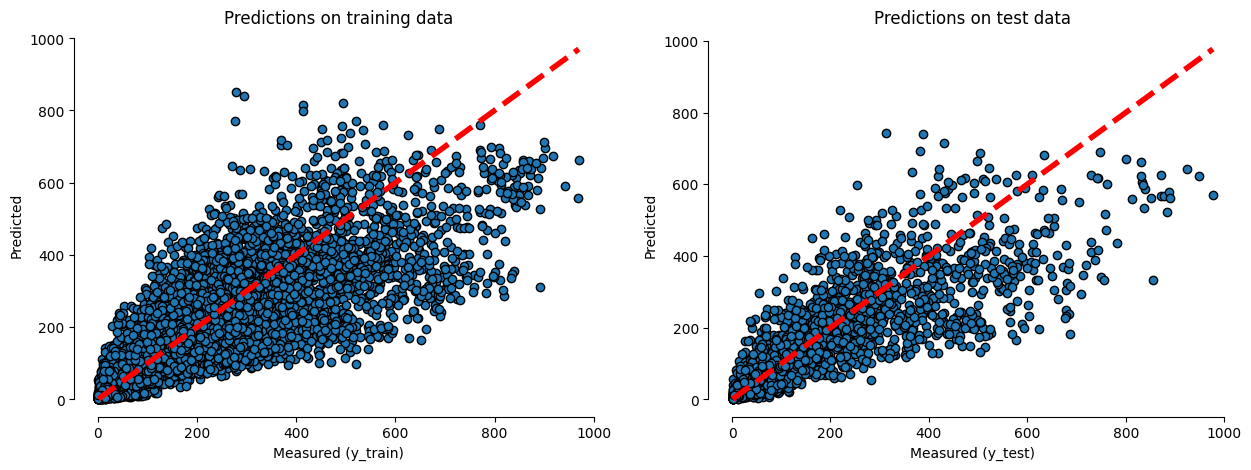

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.scatter(y_train_untrans, pipe_gridCV_trainpredictions, edgecolors=(0, 0, 0))
ax1.plot([y_train_untrans.min(), y_train_untrans.max()], [y_train_untrans.min(), y_train_untrans.max()], "r--", lw=4)
ax1.set_xlabel("Measured (y_train)")
ax1.set_ylabel("Predicted")
ax1.set_title("Predictions on training data")
ax2.scatter(y_test_untrans, pipe_gridCV_testpredictions, edgecolors=(0, 0, 0))
ax2.plot([y_test_untrans.min(), y_test_untrans.max()], [y_test_untrans.min(), y_test_untrans.max()], "r--", lw=4)
ax2.set_xlabel("Measured (y_test)")
ax2.set_ylabel("Predicted")
ax2.set_title("Predictions on test data")
sns.despine(trim=True)
plt.show()

This model doesn't perform extremely poorly. But it is clear, that some systematic variation isn't captured. Since it is mostly the extreme high rental counts (i.e., high y_train / y_test), it is likely that the model doesn't predict peak time rentals very well, in spite of our polynomial transformation (see also EDA). However, that's most likely not the only factor that causes poorer scoring.

Let's see whether another model does it better. Oftentimes, RandomForest models perform extremely well out of the box.

We run essentially the same pipeline but we will add a polynomial feature transformation on the entire preprocessed dataset (incl. categorical vars). This doesn't work at all for linear regression but seems to half a bit of an effect on RandomForest models.

In [24]:
# Build the model into pipeline
pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "polynomial",
            PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), # results in poor performance for linear regression
        ),
        (
            "regression",
            RandomForestRegressor(),
        ),
    ]
)


In [25]:
# For X:
# First, drop the dateTimeIndex/datetime column in case it hasn't been done
bike_pipe = bike.drop("datetime", axis=1)
# 1. Remove "heavy rain" of "weather" feature because it only occurs a few times
# or just assign it to the previous category
# bike_pipe = bike_pipe.drop(bike_pipe.loc[bike_pipe["weather"] == "heavy rain"].index)
bike_pipe["weather"] = bike_pipe["weather"].replace(
    to_replace="heavy rain", value="rain"
)
# 2. Retained all features in the columntransformer
features_included = np.unique(
    numeric_features
    + categorical_features
    + ordinal_features
    + ["hour", "month", "year"]
)
X = bike_pipe[features_included]
print(f"Features included into the model: {features_included}")
# For y:
# Just use "count", but if you don't scale it, your model is screwed.
# y = bike_pipe["count"]
# MinMax like helps a bit:
# y = bike_pipe["count"] / bike_pipe["count"].max()
# Log-transform is the killer, though, and conveniently the one used on Kaggle:
y = np.log1p(bike_pipe["count"])
# Check shapes
print("Shape dimensions of X and y before train_test_split: ", X.shape, y.shape)


Features included into the model: ['hour' 'humidity' 'month' 'temp' 'weather' 'workingday' 'year']
Shape dimensions of X and y before train_test_split:  (10886, 7) (10886,)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=random_state,
    # stratify=bike["count"], # We should always stratify but it is not possible here. Probably not realistic in when we are regressing but not classifying
)
print(
    "Shape dimensions of X_train, X_test, y_train and y_test after train_test_split: ",
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape,
)


Shape dimensions of X_train, X_test, y_train and y_test after train_test_split:  (8708, 7) (2178, 7) (8708,) (2178,)


In [27]:
param_grid = {
    # Random Forest Regression
    "regression__max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25],
}
pipe_gridCV = GridSearchCV(
    pipe, param_grid, cv=10, scoring="r2", refit=True, n_jobs=20
)

In [28]:
X_train.head()

,hour,humidity,month,temp,weather,workingday,year
2815,5,83,7,27.88,clear,True,0
8695,16,39,8,36.90,clear,False,1
8406,15,41,7,32.80,clear,True,1
1543,4,93,4,14.76,misty,False,0
4952,10,45,11,13.12,clear,False,0


In [29]:
y_train.head()

2815    3.583519
8695    6.111467
8406    5.624018
1543    1.791759
4952    5.303305
Name: count, dtype: float64

In [30]:
pipe_gridCV.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['temp',
                                                                          'humidity',
                                                                          'hour',
                                                                          'month',
                                                                          'year']),
                                                                        ('categoric',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['weather',
                                                                          'workingday']),
                                                                        ('poly1',
                                                                         PolynomialFeatures(degree=10,
                                                                                            include_bias=False),
                                                                         ['hour']),
                                                                        ('poly2',
                                                                         PolynomialFeatures(degree=10,
                                                                                            include_bias=False),
                                                                         ['month'])])),
                                       ('polynomial',
                                        PolynomialFeatures(include_bias=False,
                                                           interaction_only=True)),
                                       ('regression',
                                        RandomForestRegressor())]),
             n_jobs=20,
             param_grid={'regression__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   15, 20, 25]},
             scoring='r2')

In [31]:
best_params = pipe_gridCV.best_params_
print(f"Best params: {best_params}")
best_estimators = pipe_gridCV.best_estimator_.named_steps["regression"]
print(f"Best estimators: {best_estimators}")
best_score = pipe_gridCV.best_score_
print(f"The best score is {best_score:.3f}.")

Best params: {'regression__max_depth': 15}
Best estimators: RandomForestRegressor(max_depth=15)
The best score is 0.943.


Plot feature importances
Note: We can't really extract the feature names (e.g. with get_feature_names_out() of the preprocessor) because they get expanded when fitting the model and features aren't all labeled as strings (which is necessary for the RandomForestRegressor attribute feature_in_ to be created)
(see https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html)

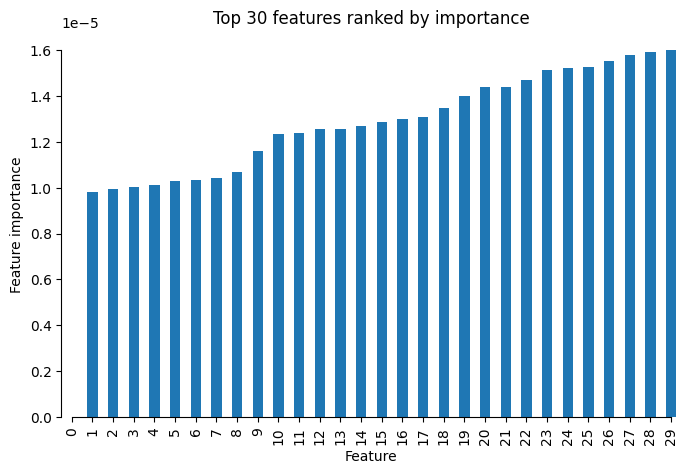

In [32]:
tree_importance_sorted_idx = np.argsort(pipe_gridCV.best_estimator_["regression"].feature_importances_)
tree_importance_sorted_idx = tree_importance_sorted_idx[:30]
feature_importances = pd.Series(pipe_gridCV.best_estimator_["regression"].feature_importances_[tree_importance_sorted_idx])
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
feature_importances.plot.bar(ax=ax1)
ax1.set_ylabel("Feature importance")
ax1.set_xlabel("Feature")
ax1.set_title("Top 30 features ranked by importance")
sns.despine(trim=True)
plt.show()

In [33]:
cv_results = pd.DataFrame(pipe_gridCV.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[
    [
        "mean_test_score",
        "std_test_score",
        "params"
    ]
].head()


,mean_test_score,std_test_score,params
9,0.942592,0.004724,{'regression__max_depth': 15}
10,0.942397,0.004928,{'regression__max_depth': 20}
11,0.942353,0.005235,{'regression__max_depth': 25}
8,0.935955,0.005933,{'regression__max_depth': 10}
7,0.928531,0.006582,{'regression__max_depth': 9}


In [34]:
pipe_gridCV_trainpredictions = pipe_gridCV.predict(X_train)
pipe_gridCV_testpredictions = pipe_gridCV.predict(X_test)

In [35]:
pipe_gridCV_trainpredictions = np.exp(pipe_gridCV_trainpredictions) - 1
pipe_gridCV_testpredictions = np.exp(pipe_gridCV_testpredictions) - 1
y_train_untrans = np.exp(y_train) - 1
y_test_untrans = np.exp(y_test) - 1

In [36]:
print(f"Model score {pipe_gridCV.scoring} on training data: ", pipe_gridCV.score(X_train, y_train))
print(f"Model score {pipe_gridCV.scoring} on test data: ", pipe_gridCV.score(X_test, y_test))

Model score r2 on training data:  0.9888188578262593
Model score r2 on test data:  0.9463419394715694


In [37]:
RMSLE_train = np.sqrt(mean_squared_log_error(y_train_untrans, pipe_gridCV_trainpredictions))
RMSLE_test = np.sqrt(mean_squared_log_error(y_test_untrans, pipe_gridCV_testpredictions))
print(f"Model score RMSLE on training data: ", RMSLE_train)
print(f"Model score RMSLE on test data: ", RMSLE_test)

Model score RMSLE on training data:  0.14967741514315952
Model score RMSLE on test data:  0.3323483061661986


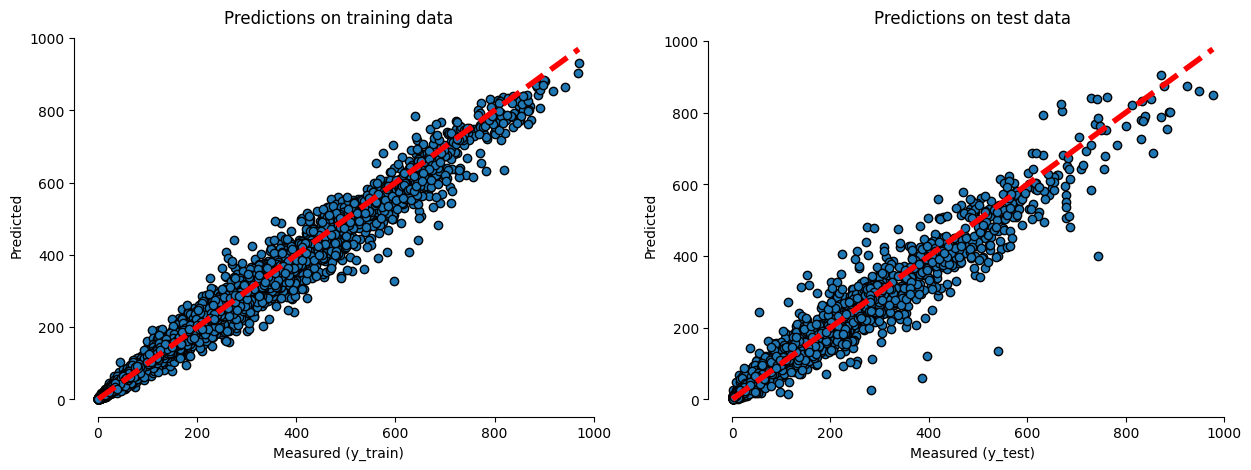

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.scatter(y_train_untrans, pipe_gridCV_trainpredictions, edgecolors=(0, 0, 0))
ax1.plot([y_train_untrans.min(), y_train_untrans.max()], [y_train_untrans.min(), y_train_untrans.max()], "r--", lw=4)
ax1.set_xlabel("Measured (y_train)")
ax1.set_ylabel("Predicted")
ax1.set_title("Predictions on training data")
ax2.scatter(y_test_untrans, pipe_gridCV_testpredictions, edgecolors=(0, 0, 0))
ax2.plot([y_test_untrans.min(), y_test_untrans.max()], [y_test_untrans.min(), y_test_untrans.max()], "r--", lw=4)
ax2.set_xlabel("Measured (y_test)")
ax2.set_ylabel("Predicted")
ax2.set_title("Predictions on test data")
sns.despine(trim=True)
plt.show()

This model does way better. It is clear, though, that it also overfits considerably, which is in general a problem with RandomForest models.
A model that wasn't tested but tends to excel in these kinds of task and could be tested as the next step is the XGBoost model.